## Description of the task and dataset

In [6]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#input data initialization
train_data_path = '../cases/data/scoring/scoring_train.csv'
test_data_path = '../cases/data/scoring/scoring_test.csv'
df = pd.read_csv(train_data_path)
df.head(10)

,ID,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30.59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60.89DaysPastDueNotWorse,NumberOfDependents,target
0,0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1
1,1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0
2,2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0
3,3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0
4,4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0
5,5,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0,0
6,6,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0,0
7,7,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0,0
8,8,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN,0
9,9,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0,0


In [7]:
## Baseline model

from fedot.api.main import Fedot

#task selection, initialisation of the framework
baseline_model = Fedot(problem='classification')

#fit model without optimisation - single XGBoost node is used 
baseline_model.fit(features=train_data_path, target='target', predefined_model='xgboost')

#evaluate the prediction with test data
baseline_model.predict(features=test_data_path)

#evaluate quality metric for the test sample
baseline_roc_auc = baseline_model.validate(metric_name='roc_auc')
print(baseline_roc_auc)

Fit chain from scratch
0.827


## FEDOT AutoML for classification

In [8]:
# new instance to be used as AutoML tool
auto_model = Fedot(problem='classification')

In [9]:
#run of the AutoML-based model generation
pipeline = auto_model.fit(features=train_data_path, target='target')

Best metric is -0.79
Generation num: 0
max_depth: 3, no improvements: 0
spent time: 2.8 min
Best metric is -0.809
Composition time: 2.767 min
Algorithm was terminated due to processing time limit
GP composition finished
Start tuning of primary nodes
End tuning
Fit chain from scratch


In [10]:
prediction = auto_model.predict(features=test_data_path)
auto_roc_auc = auto_model.validate()
print(auto_roc_auc)

0.856


In [12]:
#comparison with the manual pipeline

print('Baseline', round(baseline_roc_auc, 3))
print('AutoML solution', round(auto_roc_auc, 3))

pipeline = auto_model.current_model

Baseline 0.827
AutoML solution 0.856


## FEDOT AutoML for the time series forecasting

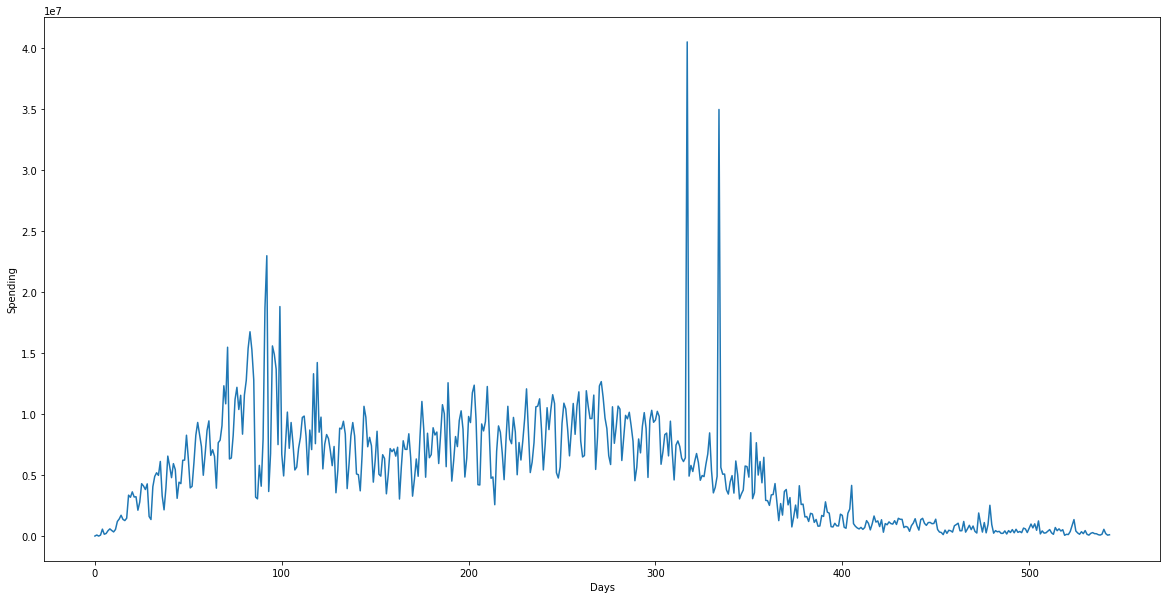

In [1]:
#read and plot the time series data

import matplotlib.pyplot as plt
import pandas as pd

train_data_path = './jupyter_media/intro/salaries.csv'
train_data = pd.read_csv(train_data_path)

plt.figure(figsize=(20,10))
plt.plot(train_data['target'])
plt.xlabel('Days')
plt.ylabel('Spending')
plt.show()

In [3]:
from fedot.api.main import Fedot

# init model for the time series forecasting
model = Fedot(problem='ts_forecasting')

D:\THEODOR\fedot\core\data\data.py:193: UserWarning: Automatic factorization for the column date with type "object" is applied.
  warnings.warn(f'Automatic factorization for the column {column_name} with type "object" is applied.')


Best metric is 4849316.1764290165
Generation num: 0
max_depth: 1, no improvements: 0
spent time: 1.0 min
Best metric is 4849316.1764290165
Composition time: 1.0 min
Algorithm was terminated due to processing time limit
GP composition finished
Fit chain from scratch


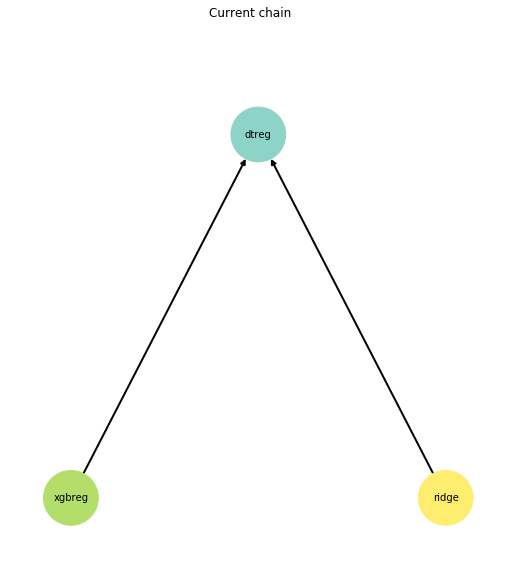

In [4]:
#run AutoML model design in the same way
chain = model.fit(features=train_data_path, target='target')
chain.show()

# use model to obtain forecast

ts_forecast = model.forecast(pre_history=train_data_path, forecast_length = 30)

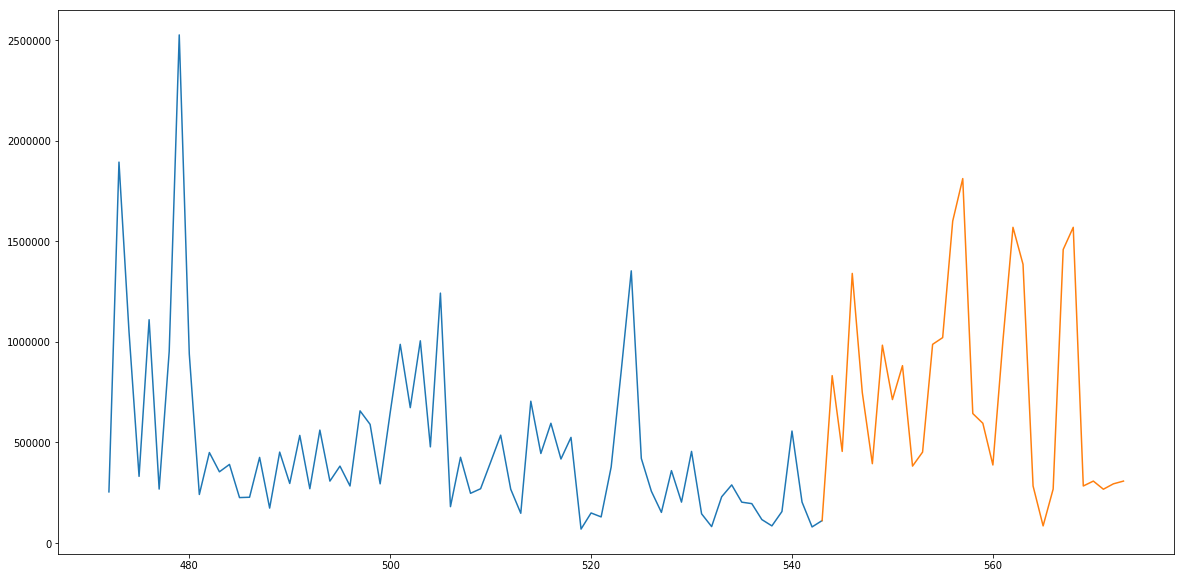

In [5]:
#plot forecasting result
model.plot_prediction()